In [10]:
%reset

from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join, isdir
import math

pre_processed_dir = './Pre-processed data'

processed_files = [file for file in listdir(pre_processed_dir) if (isfile(join(pre_processed_dir, file))) and ('trx' in file)]

processed_files.sort()         #Will sort according to the date just in case it is not already sorted

print("---------------------Pre-Processed files---------------------")
print(processed_files)
print("-------------------------------------------------------------")

---------------------Pre-Processed files---------------------
['20150402_trx.txt', '20150506_trx.txt', '20150602_trx.txt', '20150701_trx.txt', '20150801_trx.txt', '20150829_trx.txt', '20150926_trx.txt', '20151031_trx.txt', '20151128_trx.txt', '20160109_trx.txt', '20160130_trx.txt', '20160227_trx.txt', '20160402_trx.txt', '20160430_trx.txt', '20160528_trx.txt', '20160630_trx.txt', '20160730_trx.txt', '20160827_trx.txt', '20160930_trx.txt', '20161028_trx.txt', '20161126_trx.txt', '20161224_trx.txt', '20170128_trx.txt', '20170225_trx.txt', '20170401_trx.txt', '20170429_trx.txt', '20170531_trx.txt', '20170701_trx.txt', '20170729_trx.txt', '20170831_trx.txt', '20171005_trx.txt', '20171031_trx.txt', '20171130_trx.txt', '20171222_trx.txt', '20180131_trx.txt', '20180228_trx.txt', '20180330_trx.txt', '20180427_trx.txt', '20180531_trx.txt', '20180629_trx.txt', '20180801_trx.txt', '20180831_trx.txt', '20180930_trx.txt', '20181031_trx.txt', '20181130_trx.txt', '20181231_trx.txt', '20190131_trx.txt

In [11]:
from mast_estimations import get_suburban_mast_cost, get_urban_mast_cost, get_rural_mast_cost

def calculate_support_cost(row):
    cat = int(row['CAT'])
    if cat <= 1:
        return get_rural_mast_cost(max(row['ANT_HEIGHT'], 5))
    elif cat <= 3:
        return get_suburban_mast_cost(max(row['ANT_HEIGHT'], 5))
    else:
        return get_urban_mast_cost()

In [12]:
# Constants (all in kg CO2e/year)
AU_HEPTABAND_CC = 2.1e1
AU_RU_3500_CC = 1.5e2
RU_CC = 3.4e1
BU_CC = 4.5e1


def get_total_cost(all_df: pd.DataFrame):
    # One BU per 6 transceiver, with a minimum of 1 BU per BS

    total_BU_cost = BU_CC * all_df.groupby("BS_ID").size().apply(lambda x: math.ceil(x / 6)).sum()

    # Calculating costs of antenna towers (one per support)
    all_df["ANT_HEIGHT"] = all_df["ANT_HEIGHT"].astype(float)
    sup_df = all_df.groupby(["SUP_ID", "CAT"])["ANT_HEIGHT"].max()
    sup_df = sup_df.reset_index()
    sup_df["MAST_CC"] = sup_df.apply(calculate_support_cost, axis=1)
    total_mast_cost = sup_df["MAST_CC"].sum()
    total_cat1_cost = sup_df[sup_df["CAT"] == '0']["MAST_CC"].sum()
    total_cat2_cost = sup_df[sup_df["CAT"] == '1']["MAST_CC"].sum()
    total_cat3_cost = sup_df[sup_df["CAT"] == '2']["MAST_CC"].sum()
    total_cat4_cost = sup_df[sup_df["CAT"] == '3']["MAST_CC"].sum()
    total_cat5_cost = sup_df[sup_df["CAT"] == '4']["MAST_CC"].sum()
    total_cat6_cost = sup_df[sup_df["CAT"] == '5']["MAST_CC"].sum()

    # One AAU per 3500 antenna
    nr_3500_df: pd.DataFrame = all_df[all_df["System"].str.contains("3500")]
    nr_3500_df = nr_3500_df.drop_duplicates(subset=["ANT_ID"])
    total_AAU_cost = AU_RU_3500_CC * nr_3500_df.shape[0]

    # One RU per non-3500 transceiver
    other_df: pd.DataFrame = all_df[~all_df["System"].str.contains("3500")]
    total_RU_cost = RU_CC * other_df.shape[0]

    # One AU per 3500 antenna
    other_ant_df = other_df.drop_duplicates(subset=["ANT_ID"])
    total_AU_cost = AU_HEPTABAND_CC * other_ant_df.shape[0]
    
    recent_df: pd.DataFrame = all_df[all_df["System"].str.contains("LTE") | all_df["System"].str.contains("NR")]

    costs = (
        total_cat1_cost,
        total_cat2_cost,
        total_cat3_cost,
        total_cat4_cost,
        total_cat5_cost,
        total_cat6_cost,
        total_AAU_cost,
        total_RU_cost,
        total_BU_cost,
        total_AU_cost,
    )

    counts = (
        sup_df[sup_df["CAT"] == '0'].shape[0],
        sup_df[sup_df["CAT"] == '1'].shape[0],
        sup_df[sup_df["CAT"] == '2'].shape[0],
        sup_df[sup_df["CAT"] == '3'].shape[0],
        sup_df[sup_df["CAT"] == '4'].shape[0],
        sup_df[sup_df["CAT"] == '5'].shape[0],
        nr_3500_df.shape[0],
        other_df.shape[0],
        other_ant_df.shape[0],
        recent_df.shape[0],
    )

    return costs, counts

In [13]:
all_df = pd.read_csv(join(pre_processed_dir, "20221223_trx.txt"), sep = ';', dtype=str)
# print unique ANT_TYPE
# all_df = all_df[['ANT_ID', 'OPR_NAME']].drop_duplicates().groupby(['ANT_ID']).size().reset_index().rename(columns={0:'count'})
# print(all_df[
#     (all_df['count'] > 1)
# ])

all_df.groupby("BS_ID").size().apply(lambda x: math.ceil(x / 6)).sum()

311225

In [14]:
interpolated_counts = []

def plot_total_costs(dates, mast_costs, aau_costs, ru_costs, bu_costs, au_costs, total_costs):
    plt.plot(dates, np.array(mast_costs) / 10**3 / 10**3, color='green', label='Mast', linewidth=5)
    plt.plot(dates, np.array(aau_costs) / 10**3 / 10**3, color='orange', label='AAU', linewidth=5)
    plt.plot(dates, np.array(ru_costs) / 10**3 / 10**3, color='red', label='RU', linewidth=5)
    plt.plot(dates, np.array(bu_costs) / 10**3 / 10**3, color='blue', label='BU', linewidth=5)
    plt.plot(dates, np.array(au_costs) / 10**3 / 10**3, color='yellow', label='AU', linewidth=5)
    plt.plot(dates, np.array(total_costs) / 10**3 / 10**3, color='pink', label='Total', linewidth=5)
    plt.axvline(x = datetime(2020, 12, 1), color = 'b', linestyle='dashed')
    
    recent_dates = [date for date in dates if date.year >= 2023]
    x = np.arange(len(recent_dates))
    y = (np.array(bu_costs) / 10**3)[-len(x):]   
    m, b = np.polyfit(x, y, 1)
    last_date = sorted(recent_dates)[-1]
    recent_dates = recent_dates + [last_date + timedelta(days=365.2425/12*i) for i in range(1, 72)]
    x = np.arange(len(recent_dates))
    interpolated_counts.append(m*x + b)
    bu_interpolated = m*x + b
    # plt.plot(recent_dates, bu_interpolated, color='blue', linestyle='dashed', label='5G Linear Regression', linewidth=5)

    recent_dates = [date for date in dates if date.year >= 2023]
    x = np.arange(len(recent_dates))
    y = (np.array(nr_3500_counts))[-len(x):]   
    m, b = np.polyfit(x, y, 1)
    last_date = sorted(recent_dates)[-1]
    recent_dates = recent_dates + [last_date + timedelta(days=365.2425/12*i) for i in range(1, 72)]
    x = np.arange(len(recent_dates))
    interpolated_counts.append(m*x + b)
    nr_3500_interpolated = AU_RU_3500_CC*(m*x + b) / 10**3
    # plt.plot(recent_dates, nr_3500_interpolated, color='orange', linestyle='dashed', linewidth=5)

    recent_dates = [date for date in dates if date.year >= 2023]
    recent_len = len(recent_dates)
    x = np.arange(len(recent_dates))
    y = (np.array(recent_counts))[-len(x):]   
    m, b = np.polyfit(x, y, 1)
    last_date = sorted(recent_dates)[-1]
    recent_dates = recent_dates + [last_date + timedelta(days=365.2425/12*i) for i in range(1, 72)]
    x = np.arange(len(recent_dates))
    interpolated_counts.append(m*x + b)
    ru_interpolated = RU_CC*(m*x + b) / 10**3
    # plt.plot(recent_dates[recent_len:], ru_interpolated[recent_len:], color='red', linestyle='dashed', linewidth=5)

    recent_dates = [date for date in dates if date.year >= 2023]
    recent_len = len(recent_dates)
    x = np.arange(len(recent_dates))
    y = (np.array(ant_counts))[-len(x):]   
    m, b = np.polyfit(x, y, 1)
    last_date = sorted(recent_dates)[-1]
    recent_dates = recent_dates + [last_date + timedelta(days=365.2425/12*i) for i in range(1, 72)]
    x = np.arange(len(recent_dates))
    interpolated_counts.append(m*x + b)
    au_interpolated = AU_HEPTABAND_CC*(m*x + b) / 10**3
    # plt.plot(recent_dates[recent_len:], au_interpolated[recent_len:], color='yellow', linestyle='dashed', label='5G Linear Regression', linewidth=5)
    
    plt.legend(fontsize=21)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.ylabel("Carbon footprint (ktCO2eq/year)", fontsize=24)
    plt.xlabel("Date", fontsize=24)

    plt.ylim(ymin = 0)
    plt.tight_layout()
    # Save Image
    plt.savefig('./Graphs/Carbon_costs.pdf')
    # Show graphic
    plt.show()
    
    return

In [15]:
dates = []
sup_costs = [[], [], [], [], [], []]
mast_costs = []
sup_counts = [[], [], [], [], [], []]
AAU_costs = []
RU_costs = []
BU_costs = []
AU_costs = []
total_costs = []
nr_3500_counts = []
trx_counts = []
ant_counts = []
recent_counts = []
avg_ops_per_site = []
count_op_site = [[], [], [], []]
colocated_supports = []

# for file in processed_files:
#     print('------------Currently Processing------------')
#     print(file)
#     print('--------------------------------------------')
    
#     date = file.split('_trx')[0]
#     dates.append(datetime.strptime(date, '%Y%m%d'))


for file in processed_files:
    print('------------Currently Processing------------')
    print(file)
    print('--------------------------------------------')
    
    date = file.split('_trx')[0]
    dates.append(datetime.strptime(date, '%Y%m%d'))
    
    #-------------Reading the current preprocessed file-------------#
    all_df = pd.read_csv(join(pre_processed_dir, file), sep = ';', dtype=str)
    all_df['ANT_HEIGHT'] = all_df['ANT_HEIGHT'].astype(float)
    
    cut_df = all_df[['OPR_NAME', 'SUP_ID']].drop_duplicates().groupby(['SUP_ID']).size().reset_index().rename(columns={0:'count'})
    avg_ops_per_site.append(cut_df['count'].sum()/len(cut_df['SUP_ID'].unique()))
    for i in range(4):
        count_op_site[i].append(len(cut_df[cut_df['count'] == i+1]))
        print(count_op_site[i][-1])
        
    merged_supports = all_df[['OPR_NAME', 'SUP_ID']].drop_duplicates().groupby(['SUP_ID']).size().reset_index().rename(columns={0:'count'})
    colocated_supports.append(len(merged_supports[
        (merged_supports['count'] > 1)
    ]['SUP_ID'].unique()))
    
    #------------Condensing data more by introducing a count column for TRX with exactly same characteristics------------#
    costs, counts = get_total_cost(all_df)
    
    # add value to lists
    for i in range(6):
        sup_costs[i].append(costs[i])
        sup_counts[i].append(counts[i])
        
    mast_costs.append(sum(costs[:6]))
    AAU_costs.append(costs[6])
    RU_costs.append(costs[7])
    BU_costs.append(costs[8])
    AU_costs.append(costs[9])
    nr_3500_counts.append(counts[6])
    trx_counts.append(counts[7])
    ant_counts.append(counts[8])
    recent_counts.append(counts[9])
    
    total_costs.append(sum(costs))
    

------------Currently Processing------------
20150402_trx.txt
--------------------------------------------
28187
8350
3989
572
------------Currently Processing------------
20150506_trx.txt
--------------------------------------------
28140
8398
4028
593
------------Currently Processing------------
20150602_trx.txt
--------------------------------------------
28148
8413
4052
601
------------Currently Processing------------
20150701_trx.txt
--------------------------------------------
28157
8436
4068
616
------------Currently Processing------------
20150801_trx.txt
--------------------------------------------
28120
8457
4107
632
------------Currently Processing------------
20150829_trx.txt
--------------------------------------------
28097
8498
4129
643
------------Currently Processing------------
20150926_trx.txt
--------------------------------------------
28095
8506
4149
652
------------Currently Processing------------
20151031_trx.txt
--------------------------------------------
2811

0.003977201172618956 1.5219616417341997


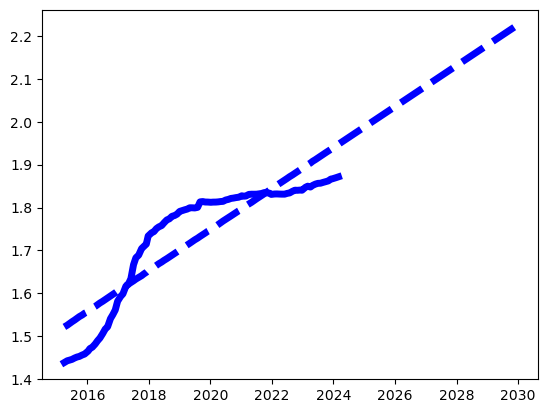

In [16]:
# polyfit
recent_dates = [date for date in dates]
x = np.arange(len(recent_dates))
m, b = np.polyfit(x, avg_ops_per_site[-len(recent_dates):], 1)
recent_dates = recent_dates + [recent_dates[-1] + timedelta(days=365.2425/12*i) for i in range(1, 70)]
x = np.arange(len(recent_dates))
plt.plot(recent_dates, m*x + b, color='blue', linestyle='dashed', label='Total Power Linear Regression', linewidth=5)
plt.plot(dates, avg_ops_per_site, color='blue', label='Total Power', linewidth=5)

print(m, b)

138.1713122171948 25273.187782805428
48.98868778280547 10010.067119155348
10.128144796380145 6325.286576168927
70.2238009049775 4989.4245852187005


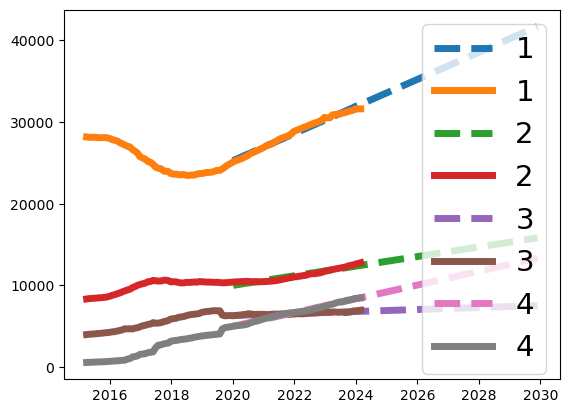

1.904465841980852
149370.85085972858
78431.88760180998


In [17]:
C_2030 = 0
N_2030 = 0

# Extrapolated number of sites for each number of operators in the site in 2030
N_sharing_2030 = [0, 0, 0, 0]

for i in range(4):
    recent_dates = [date for date in dates if date.year >= 2020]
    x = np.arange(len(recent_dates))
    m, b = np.polyfit(x, count_op_site[i][-len(recent_dates):], 1)
    recent_dates = recent_dates + [recent_dates[-1] + timedelta(days=365.2425/12*i) for i in range(1, 70)]
    x = np.arange(len(recent_dates))
    plt.plot(recent_dates, m*x + b, linestyle='dashed', label=f'{i + 1}', linewidth=5)
    plt.plot(dates, count_op_site[i], label=f'{i + 1}', linewidth=5)
    C_2030 += (i+1) * (m*x + b)[-1]
    N_2030 += (m*x + b)[-1]
    N_sharing_2030[i] = (m*x + b)[-1]

    print(m, b)
    
plt.legend(fontsize=21)
plt.show()

print(sum([(i +1 )* N_sharing_2030[i] / N_2030 for i in range(4)]))

print(C_2030)
print(N_2030)

In [18]:
# Ideal proportion of sites with 1, 2, 3, 4 operators
shared_proportions_2030 = [N_sharing_2030[i + 1] / sum(N_sharing_2030[1:]) for i in range(3)]
avg_number_op_per_site_goal = 2.5
print((sum([(i + 2) * shared_proportions_2030[i] for i in range(3)]) - 1))
N_1 = C_2030 * (sum([(i + 2) * shared_proportions_2030[i] / 2.5 for i in range(3)]) - 1) / (sum([(i + 2) * shared_proportions_2030[i] for i in range(3)]) - 1)
print(N_1)
N_2 = shared_proportions_2030[0] * (C_2030 / avg_number_op_per_site_goal - N_1)
N_3 = shared_proportions_2030[1] * (C_2030 / avg_number_op_per_site_goal - N_1)
N_4 = shared_proportions_2030[2] * (C_2030 / avg_number_op_per_site_goal - N_1)
N_sharing_ideal = np.array([N_1, N_2, N_3, N_4])
print(N_sharing_ideal)

N_2030_SHARING = sum([N_sharing_ideal[i] for i in range(4)])

AVG_2030 = sum([(i+1) * N_sharing_ideal[i] for i in range(4)]) / N_2030_SHARING
print(N_2030_SHARING)
print(AVG_2030)
SHARING_RATIO = N_2030_SHARING / N_2030
print(SHARING_RATIO)

1.932082940157347
13361.868700733923
[13361.86870073 20011.50698552  9513.8904426  16861.07421504]
59748.340343891425
2.5000000000000004
0.7617863367923406


In [19]:
# All in gCO2eq/Kwh

CARBON_INTENSITIES = [
    36, # 2021 https://www.rte-france.com/actualites/bilan-electrique-2021
    56, # 2022 https://www.rte-france.com/actualites/bilan-electrique-2022
    32 # 2023 https://www.rte-france.com/actualites/bilan-electrique-france-2023-nouvel-equilibre-systeme-electrique
]

# Émissions totales https://analysesetdonnees.rte-france.com/emission/emission-ges
# Consommation totale https://www.edf.fr/groupe-edf/espaces-dedies/jeunes-enseignants/pour-les-jeunes/lenergie-de-a-a-z/lelectricite-au-quotidien/la-consommation-delectricite-en-chiffres
# (corrigée du climat)
CARBON_INTENSITIES = [
    19.8 / 0.474,
    23.6 / 0.474,
    28.1 / 0.474,
    20.2 / 0.474,
    19.2 / 0.474,
    17.4 / 0.474,
    36, # 2021 https://www.rte-france.com/actualites/bilan-electrique-2021
    56, # 2022 https://www.rte-france.com/actualites/bilan-electrique-2022
    32, # 2023 https://www.rte-france.com/actualites/bilan-electrique-france-2023-nouvel-equilibre-systeme-electrique
    32
]

# source https://www.rte-france.com/analyses-tendances-et-prospectives/bilan-previsionnel-2050-futurs-energetiques#Lesresultatsdeletude
OPT_CARBON_INTENSITIES = [20 * i/6 + 32 * (6 - i)/6 for i in range(1, 7)]
PES_CARBON_INTENSITIES = [32] * 6

print(CARBON_INTENSITIES, OPT_CARBON_INTENSITIES, PES_CARBON_INTENSITIES)

[41.77215189873418, 49.789029535864984, 59.28270042194094, 42.61603375527426, 40.50632911392405, 36.70886075949367, 36, 56, 32, 32] [30.0, 28.0, 26.0, 24.0, 22.0, 20.0] [32, 32, 32, 32, 32, 32]


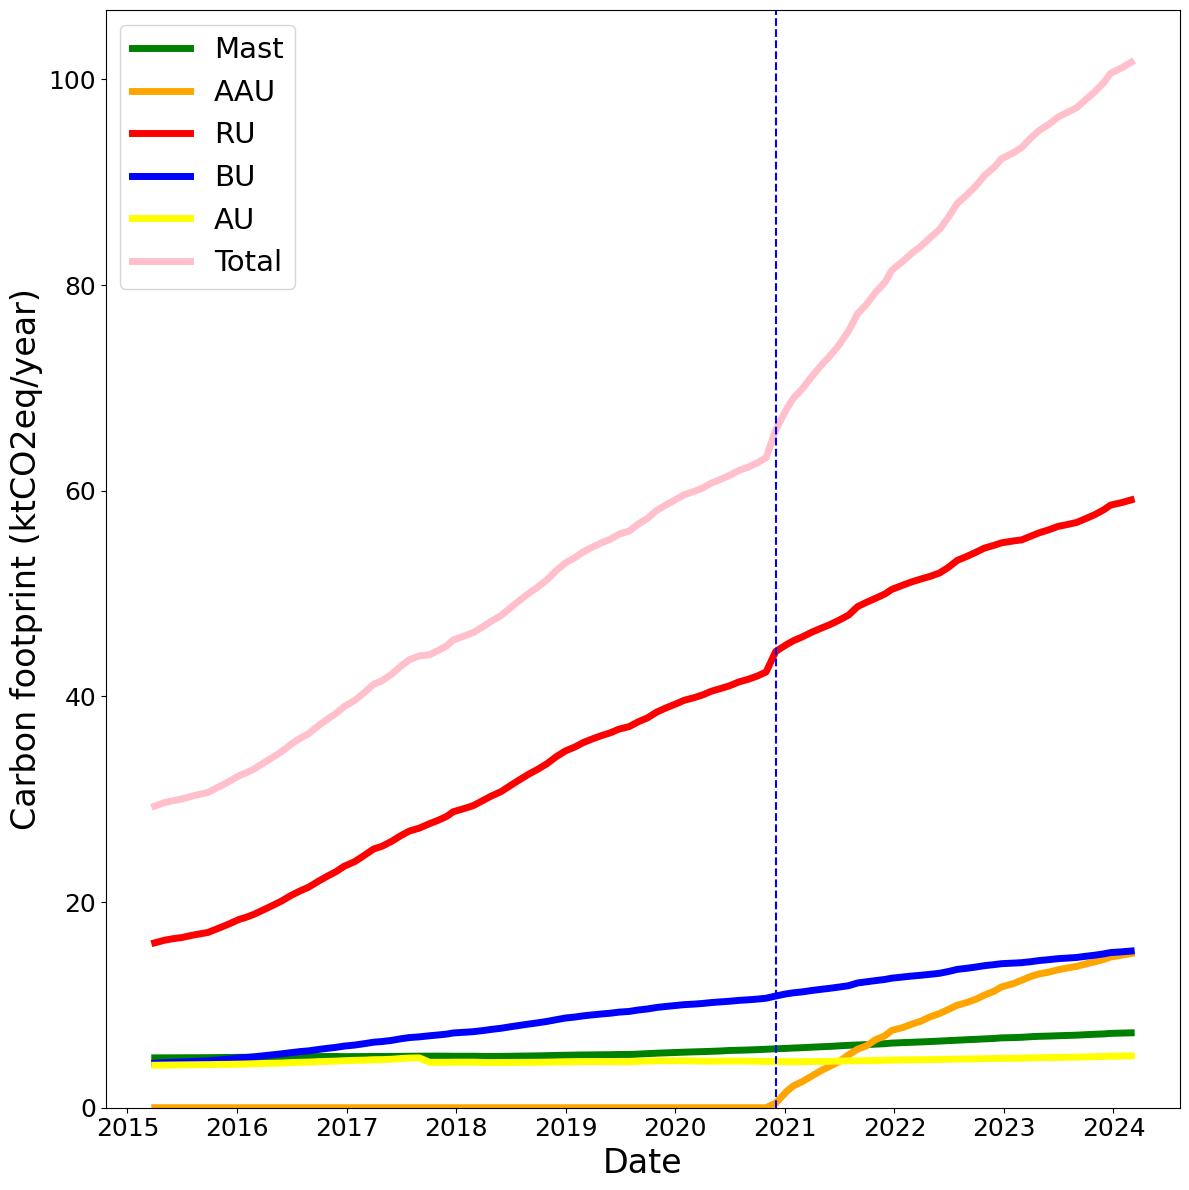

In [20]:
plt.rcParams["figure.figsize"] = (12,12) 
plot_total_costs(dates, mast_costs, AAU_costs, RU_costs, BU_costs, AU_costs, total_costs)

-0.006959335870258814 5.925439551292424


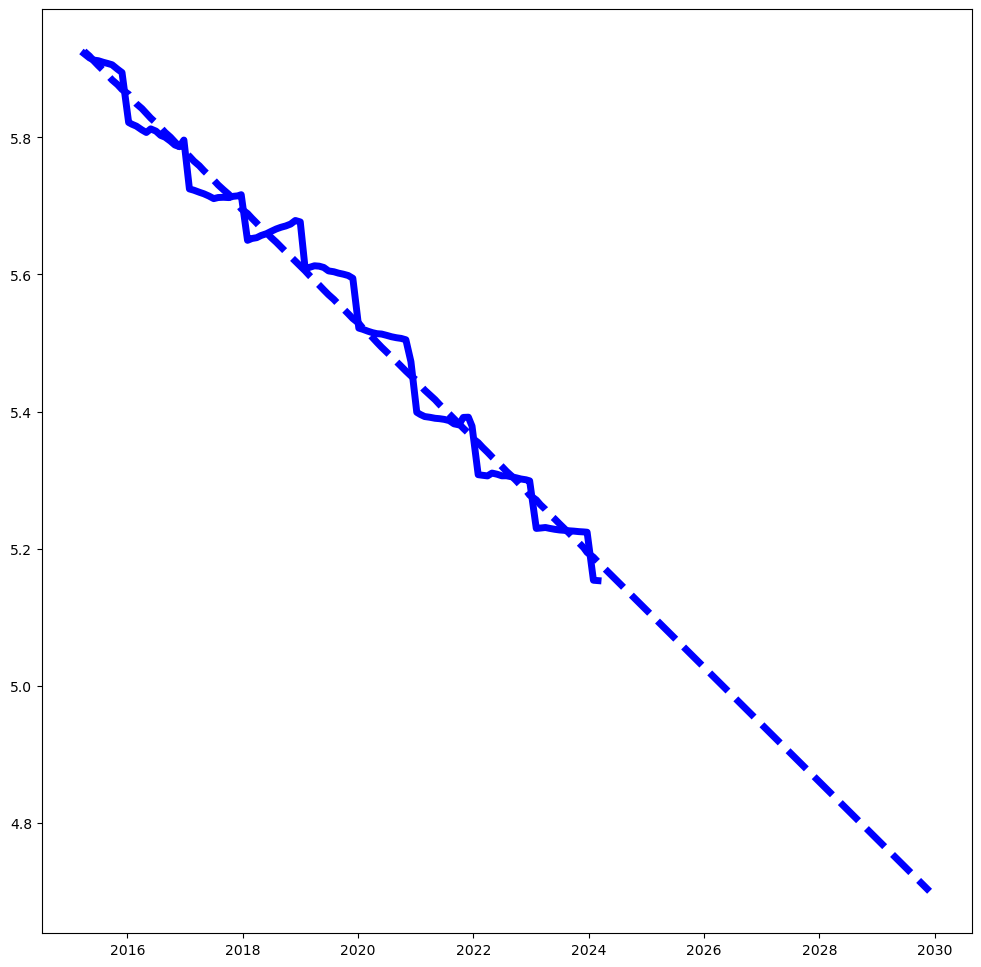

In [21]:
trx_avg_pw = pd.read_csv('./TRX_avg_pw.csv', header=0, sep = ',', dtype=str)
total_pw_main_opr = trx_avg_pw['TRX_avg_pw_M'].astype(float)
# polyfit
recent_dates = [date for date in dates]
x = np.arange(len(recent_dates))
m, b = np.polyfit(x, np.log(total_pw_main_opr[-len(recent_dates):]), 1)
recent_dates = recent_dates + [recent_dates[-1] + timedelta(days=365.2425/12*i) for i in range(1, 70)]
x = np.arange(len(recent_dates))
plt.plot(recent_dates, m*x + b, color='blue', linestyle='dashed', label='Total Power Linear Regression', linewidth=5)
plt.plot(dates, np.log(total_pw_main_opr), color='blue', label='Total Power', linewidth=5)

print(m, b)


-0.006959335870258814 5.925439551292424
0.9196115007834276
9.625036431267509e-05 0.0002785498384394831


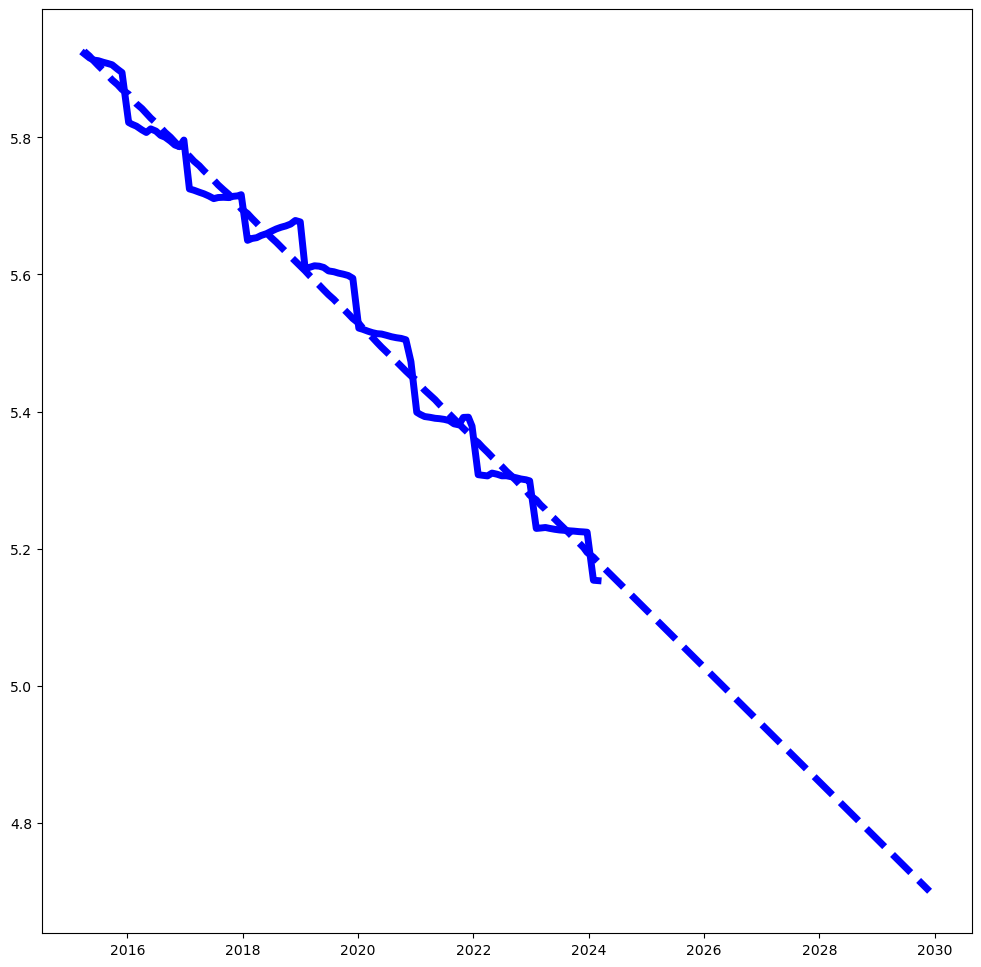

In [22]:
trx_avg_pw = pd.read_csv('./TRX_avg_pw.csv', header=0, sep = ',', dtype=str)
trx_avg_pw_low = pd.read_csv('./TRX_avg_pw_low.csv', header=0, sep = ',', dtype=str)
trx_avg_pw_high = pd.read_csv('./TRX_avg_pw_high.csv', header=0, sep = ',', dtype=str)

total_pw_main_opr = trx_avg_pw['TRX_avg_pw_M'].astype(float)
# polyfit
recent_dates = [date for date in dates]
x = np.arange(len(recent_dates))
m, b = np.polyfit(x, np.log(total_pw_main_opr[-len(recent_dates):]), 1)
recent_dates = recent_dates + [recent_dates[-1] + timedelta(days=365.2425/12*i) for i in range(1, 70)]
x = np.arange(len(recent_dates))
plt.plot(recent_dates, m*x + b, color='blue', linestyle='dashed', label='Total Power Linear Regression', linewidth=5)
plt.plot(dates, np.log(total_pw_main_opr), color='blue', label='Total Power', linewidth=5)

print(m, b)
base_modernistation_rate = (1+m)**12
print(base_modernistation_rate)
base_modernistation_rate_low = 0.98
base_modernistation_rate_high = 0.85


AVG_PW_LTE_2030 = total_pw_main_opr.iloc[-1] * (base_modernistation_rate**7) / 10**6
AVG_PW_LTE_HIGH = trx_avg_pw_high['TRX_avg_pw_M_high'].astype(float).iloc[-1]  / 10**6
AVG_PW_LTE_2030_HIGH = trx_avg_pw_high['TRX_avg_pw_M_high'].astype(float).iloc[-1] * (base_modernistation_rate_high**7) / 10**6
AVG_PW_LTE_LOW = trx_avg_pw_low['TRX_avg_pw_M_low'].astype(float).iloc[-1]  / 10**6
AVG_PW_LTE_2030_LOW = trx_avg_pw_low['TRX_avg_pw_M_low'].astype(float).iloc[-1] * (base_modernistation_rate_low**7) / 10**6
AVG_PW_LTE_2030_MODERN = total_pw_main_opr.iloc[-1] * (0.85**7) / 10**6

LOAD_COMPENSATION_FACTOR = 30/25 # compensating for lower load for 5G used in 2024 calculations

AVG_PW_NR_2030 = LOAD_COMPENSATION_FACTOR * trx_avg_pw['TRX_avg_pw_U'].astype(float).iloc[-1] * (base_modernistation_rate**7) / 10**6
AVG_PW_NR_HIGH = trx_avg_pw_high['TRX_avg_pw_U_high'].astype(float).iloc[-1]  / 10**6
AVG_PW_NR_2030_HIGH = LOAD_COMPENSATION_FACTOR * trx_avg_pw_high['TRX_avg_pw_U_high'].astype(float).iloc[-1] * (base_modernistation_rate_high**7) / 10**6
AVG_PW_NR_LOW = trx_avg_pw_low['TRX_avg_pw_U_low'].astype(float).iloc[-1]  / 10**6
AVG_PW_NR_2030_LOW = LOAD_COMPENSATION_FACTOR * trx_avg_pw_low['TRX_avg_pw_U_low'].astype(float).iloc[-1] * (base_modernistation_rate_low**7) / 10**6
AVG_PW_NR_2030_MODERN = LOAD_COMPENSATION_FACTOR * trx_avg_pw['TRX_avg_pw_U'].astype(float).iloc[-1] * (0.85**7) / 10**6
print(AVG_PW_LTE_2030, AVG_PW_NR_2030)

10
10
10


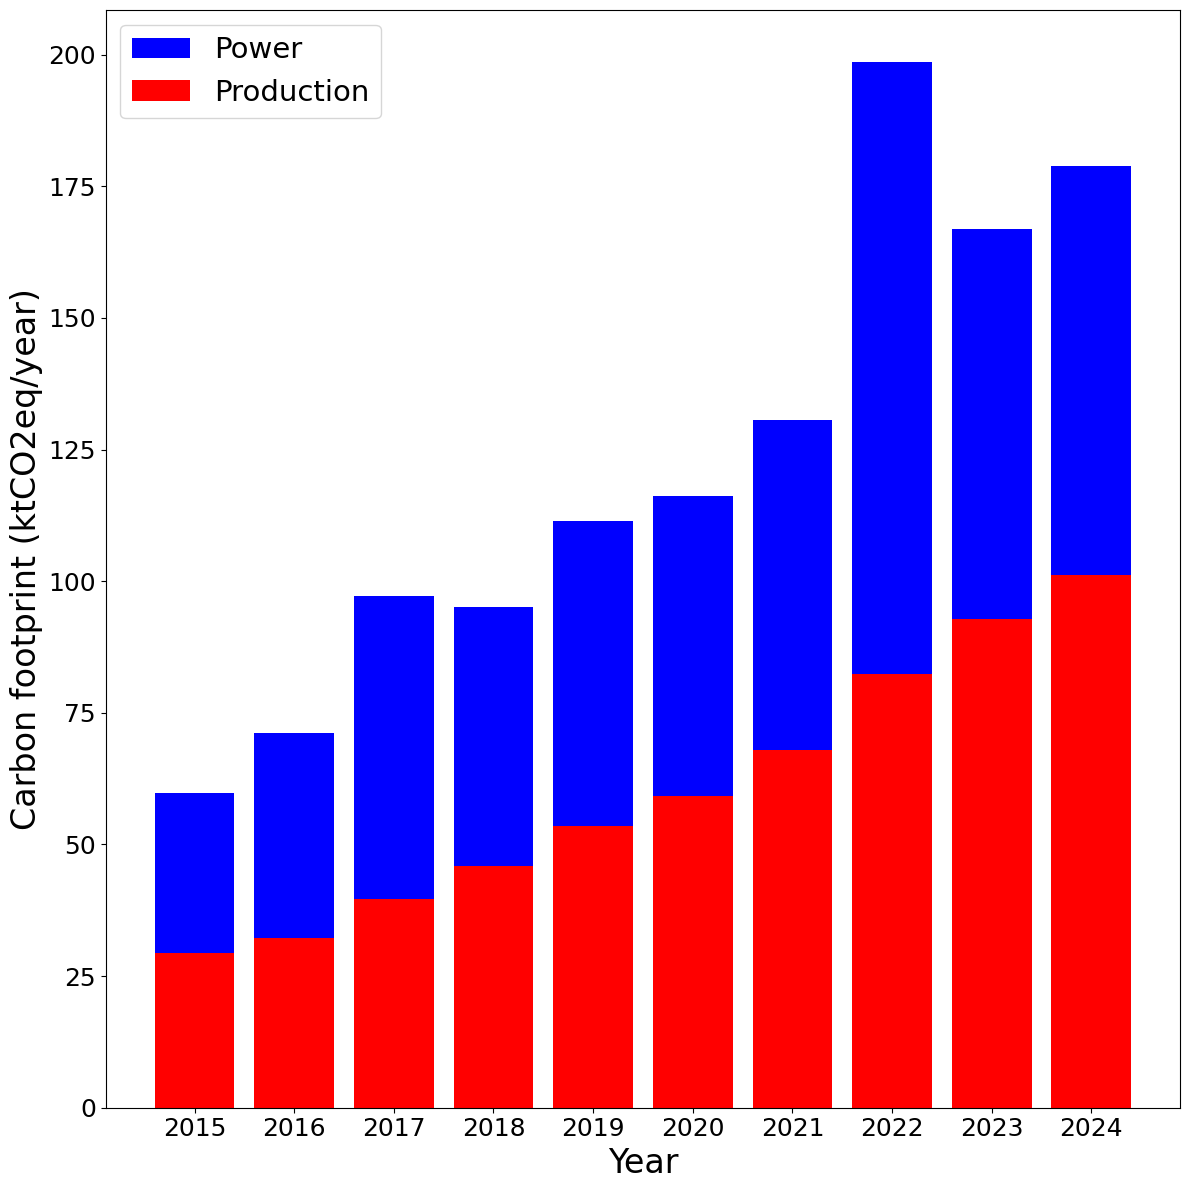

In [23]:
# find index of first 2022 date
years = [i for i in range(2015, 2025)]
indexes = []
curr_year = 0
for i in range(len(dates)):
    if dates[i].year == years[curr_year]:
        indexes.append(i)
        curr_year += 1
        if curr_year == len(years):
            break
        
# load TRX_avg_pw.csv
trx_avg_pw = pd.read_csv('./TRX_avg_pw.csv', header=0, sep = ',', dtype=str)
total_pw_main_opr = trx_avg_pw['total_pw_main_opr'].astype(float)

def convert_MW_to_kwh(MW):
    return MW * 10**3 * 24 * 365.2425

print(len(indexes))
print(len(CARBON_INTENSITIES))
print(len(years))

pw_carbon_costs = [(total_costs[indexes[i]] + total_pw_main_opr[indexes[i]] * 10**6 * CARBON_INTENSITIES[i]) / 10**3 / 10**3 for i in range(len(indexes))]
prod_carbon_costs = [total_costs[indexes[i]] / 10**3 / 10**3 for i in range(len(indexes))]

# plot total carbon cost as bar graph
plt.bar(list(range(len(indexes))), pw_carbon_costs, color='b', label='Power')
plt.bar(list(range(len(indexes))), prod_carbon_costs, color='r', label='Production')
plt.xlabel('Year', fontsize=24)
plt.ylabel('Carbon footprint (ktCO2eq/year)', fontsize=24)
plt.xticks(list(range(len(years))), years)
plt.legend(fontsize=21)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# font size of exponent
# plt.tick_params(axis='y', labelsize=18)
plt.tight_layout()
plt.savefig('./Graphs/Carbon_costs_pw.pdf')
plt.show()

In [24]:
def convert_MW_to_kwh(MW):
    return MW * 10**3 * 24 * 365.2425

convert_MW_to_kwh(300) / 1000000000

2.629746

77691.65865286125
218.69747363711602


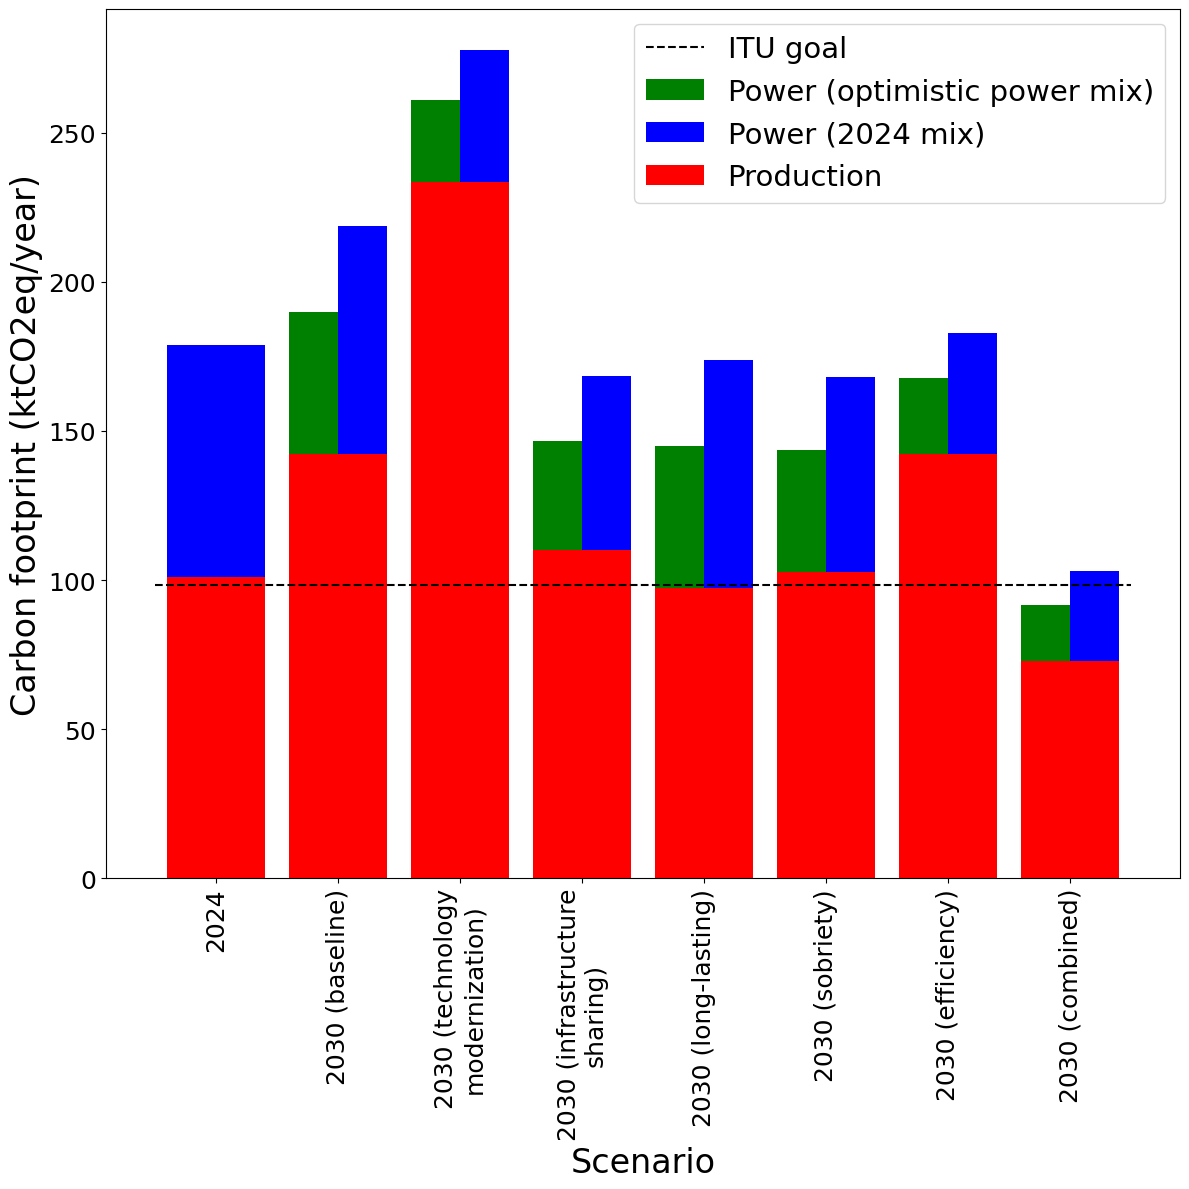

In [25]:
i_2023 = 0
for i in range(len(dates)):
    if dates[i].year == 2024 and not i_2023:
        i_2023 = i

# i_2023 = len(dates) - 1

# load TRX_avg_pw.csv
trx_avg_pw = pd.read_csv("./TRX_avg_pw.csv", header=0, sep=",", dtype=str)
total_pw_main_opr = trx_avg_pw["total_pw_main_opr"].astype(float)

# BU AAU RU AU
last_counts = [BU_costs[i_2023] / 10**3, nr_3500_counts[i_2023], trx_counts[i_2023], ant_counts[i_2023]]
interpolated_counts_2030 = [interpolated_counts[i][-1] for i in range(4)]

def calculate_sobriety_counts(counts):
    return [last_counts[i] + (counts[i] - last_counts[i]) * 0.5 for i in range(4)]


def calculate_long_lasting_counts(counts):
    return [counts[i] / 1.5 for i in range(4)]


def convert_MW_to_kwh(MW):
    return MW * 10**3 * 24 * 365.2425


def calculate_pw_carbon_cost(counts, is_optimistic):
    if is_optimistic:
        return (
            (
                convert_MW_to_kwh(AVG_PW_LTE_2030) * counts[2]
                + convert_MW_to_kwh(AVG_PW_NR_2030) * counts[1]
            )
            / 10**3
            * OPT_CARBON_INTENSITIES[-1]
        ) / 10**3
    else:
        return (
            (
                convert_MW_to_kwh(AVG_PW_LTE_2030) * counts[2]
                + convert_MW_to_kwh(AVG_PW_NR_2030) * counts[1]
            )
            / 10**3
            * CARBON_INTENSITIES[-1]
        ) / 10**3

roaming_counts = [SHARING_RATIO*interpolated_counts[i][-1] for i in range(4)]
sobriety_counts = calculate_sobriety_counts(interpolated_counts_2030)
pw_combined_counts = calculate_sobriety_counts(roaming_counts)
combined_counts = calculate_long_lasting_counts(calculate_sobriety_counts(roaming_counts))
long_lasting_counts = calculate_long_lasting_counts(interpolated_counts_2030)

# energy efficency : multiply by 0.85 ^7 / 0.93 ^ 7

pw_carbon_cost_2023 = (
    total_pw_main_opr[i_2023] * CARBON_INTENSITIES[-1]
) * 10**3
print(pw_carbon_cost_2023)
opt_pw_carbon_cost_2030_base = calculate_pw_carbon_cost(interpolated_counts_2030, True)
pess_pw_carbon_cost_2030_base = calculate_pw_carbon_cost(interpolated_counts_2030, False)
opt_pw_carbon_cost_2030_modern = (
    (
        convert_MW_to_kwh(AVG_PW_LTE_2030_MODERN) * interpolated_counts_2030[2]
        + convert_MW_to_kwh(AVG_PW_NR_2030_MODERN) * interpolated_counts_2030[1]
    )
    / 10**3
    * OPT_CARBON_INTENSITIES[-1]
) / 10**3
pess_pw_carbon_cost_2030_modern = (
    (
        convert_MW_to_kwh(AVG_PW_LTE_2030_MODERN) * interpolated_counts_2030[2]
        + convert_MW_to_kwh(AVG_PW_NR_2030_MODERN) * interpolated_counts_2030[1]
    )
    / 10**3
    * CARBON_INTENSITIES[-1]
) / 10**3
opt_pw_carbon_cost_2030_roaming = calculate_pw_carbon_cost(roaming_counts, True)
pess_pw_carbon_cost_2030_roaming = calculate_pw_carbon_cost(roaming_counts, False)
opt_pw_carbon_cost_2030_long_lasting = opt_pw_carbon_cost_2030_base
pess_pw_carbon_cost_2030_long_lasting = pess_pw_carbon_cost_2030_base

efficiency_scenario_scaling = 0.85**7 / 0.93**7
opt_pw_carbon_cost_2030_efficiency = calculate_pw_carbon_cost(interpolated_counts_2030, True) * efficiency_scenario_scaling
pess_pw_carbon_cost_2030_efficiency = calculate_pw_carbon_cost(interpolated_counts_2030, False) * efficiency_scenario_scaling

opt_pw_carbon_cost_2030_sobriety = calculate_pw_carbon_cost(sobriety_counts, True)
pess_pw_carbon_cost_2030_sobriety = calculate_pw_carbon_cost(sobriety_counts, False)

opt_pw_carbon_cost_2030_combined = calculate_pw_carbon_cost(pw_combined_counts, True) * efficiency_scenario_scaling
pess_pw_carbon_cost_2030_combined = calculate_pw_carbon_cost(pw_combined_counts, False) * efficiency_scenario_scaling

def calculate_prod_carbon_cost(counts):
    return (
        counts[0] * 10 ** 3
        + counts[1] * AU_RU_3500_CC
        + counts[2] * RU_CC
        + counts[3] * AU_HEPTABAND_CC
        + mast_costs[-1] # TODO: fix
    ) / 10**3

prod_carbon_cost_2023 = total_costs[i_2023] / 10**3
prod_carbon_cost_2030_base = calculate_prod_carbon_cost(interpolated_counts_2030)
prod_carbon_cost_2030_modern = (
    2 * interpolated_counts_2030[0]
    + 2 * AU_RU_3500_CC * interpolated_counts_2030[1]
    + 2 * RU_CC * interpolated_counts_2030[2]
    + 2 * AU_HEPTABAND_CC * interpolated_counts_2030[3]
    + mast_costs[-1]
) / 10**3
prod_carbon_cost_2030_roaming = calculate_prod_carbon_cost(roaming_counts)
prod_carbon_cost_2030_long_lasting = calculate_prod_carbon_cost(long_lasting_counts)
prod_carbon_cost_2030_sobriety = (
    sobriety_counts[0]
    + AU_RU_3500_CC * sobriety_counts[1]
    + RU_CC * sobriety_counts[2]
    + AU_HEPTABAND_CC * sobriety_counts[3]
    + mast_costs[0] - (mast_costs[0] - mast_costs[-1]) * 0.8
) / 10**3
prod_carbon_cost_2030_combined = calculate_prod_carbon_cost(combined_counts)
prod_carbon_cost_2030_efficiency = prod_carbon_cost_2030_base

pess_carbon_costs = [
    pess_pw_carbon_cost_2030_base,
    pess_pw_carbon_cost_2030_modern,
    pess_pw_carbon_cost_2030_roaming,
    pess_pw_carbon_cost_2030_long_lasting,
    pess_pw_carbon_cost_2030_sobriety,
    pess_pw_carbon_cost_2030_efficiency,
    pess_pw_carbon_cost_2030_combined,
]
opt_carbon_costs = [
    opt_pw_carbon_cost_2030_base,
    opt_pw_carbon_cost_2030_modern,
    opt_pw_carbon_cost_2030_roaming,
    opt_pw_carbon_cost_2030_long_lasting,
    opt_pw_carbon_cost_2030_sobriety,
    opt_pw_carbon_cost_2030_efficiency,
    opt_pw_carbon_cost_2030_combined,
]

prod_carbon_costs = [
    prod_carbon_cost_2030_base,
    prod_carbon_cost_2030_modern,
    prod_carbon_cost_2030_roaming,
    prod_carbon_cost_2030_long_lasting,
    prod_carbon_cost_2030_sobriety,
    prod_carbon_cost_2030_efficiency,
    prod_carbon_cost_2030_combined,
]

opt_total_carbon_costs = [opt_carbon_costs[i] / 10**3 + prod_carbon_costs[i] / 10**3 for i in range(7)]
pess_total_carbon_costs = [pess_carbon_costs[i] / 10**3 + prod_carbon_costs[i] / 10**3 for i in range(7)]

# plot total carbon cost as bar graph
plt.bar(list(range(1, len(opt_total_carbon_costs) + 1)), opt_total_carbon_costs, color="g", label="Power (optimistic power mix)")
plt.bar([0], (prod_carbon_cost_2023 + pw_carbon_cost_2023) / 10**3, color="b")
ITU_GOAL = 0.55 * (prod_carbon_cost_2023 + pw_carbon_cost_2023) / 10**3
plt.hlines(ITU_GOAL, -0.5, 7.5, color="black", label="ITU goal", linestyles="dashed")
plt.bar([i + 0.2 for i in range (1, len(pess_total_carbon_costs) + 1)], pess_total_carbon_costs, color="b", label="Power (2024 mix)", width=0.4)
prod_carbon_cost_full_list = [prod_carbon_cost_2023] + prod_carbon_costs
prod_carbon_cost_full_list = [prod_carbon_cost_full_list[i] / 10**3 for i in range(len(prod_carbon_cost_full_list))]
plt.bar(list(range(len(prod_carbon_costs) + 1)), prod_carbon_cost_full_list, color="r", label="Production")
plt.xlabel("Scenario", fontsize=24)
plt.ylabel("Carbon footprint (ktCO2eq/year)", fontsize=24)
plt.xticks([i for i in range(len(prod_carbon_costs) + 1)], [2024, "2030 (baseline)", "2030 (technology\nmodernization)", "2030 (infrastructure\nsharing)", "2030 (long-lasting)", "2030 (sobriety)", "2030 (efficiency)", "2030 (combined)"], rotation=90)
plt.legend(fontsize=21)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
print(pess_total_carbon_costs[0])
# font size of exponent
# plt.tick_params(axis='y', labelsize=18)
plt.tight_layout()
plt.savefig("./Graphs/Carbon_costs_pw_scenarios.pdf")
plt.show()

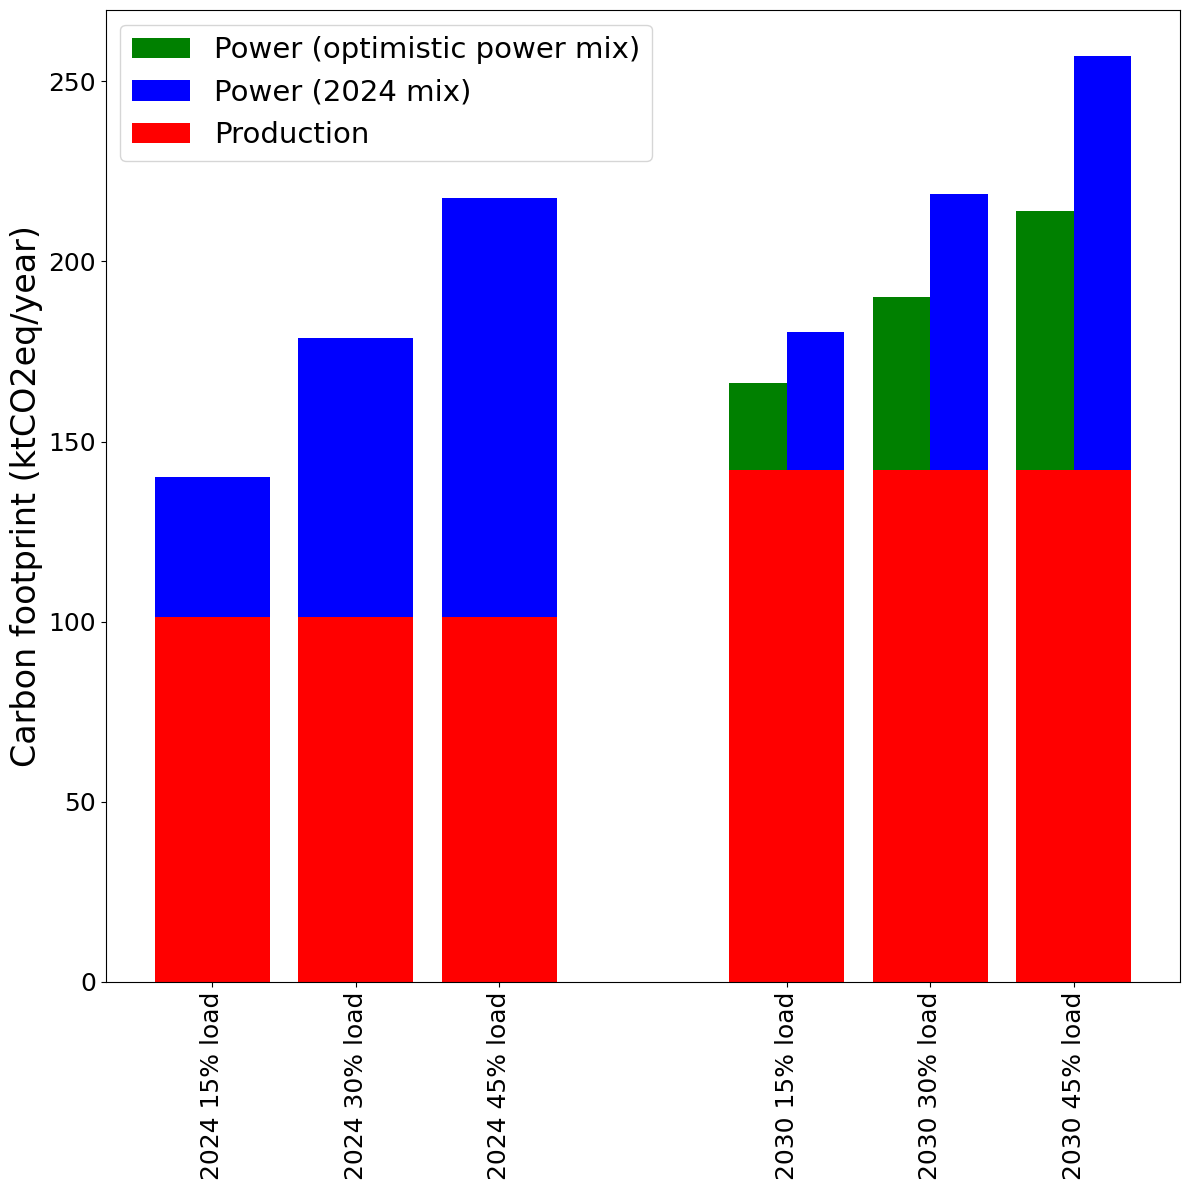

In [26]:
# Sensibility analysis

# Load
low_load = 0.15
normal_load = 0.30
high_load = 0.45

low_load_opt_carbon_cost = opt_carbon_costs[0] * low_load / normal_load
low_load_pess_carbon_cost = pess_carbon_costs[0] * low_load / normal_load
low_load_pw_carbon_cost_2023 = pw_carbon_cost_2023 * low_load / normal_load
low_load_opt_total_carbon_cost = low_load_opt_carbon_cost + prod_carbon_costs[0]
low_load_pess_total_carbon_cost = low_load_pess_carbon_cost + prod_carbon_costs[0]
low_load_total_carbon_cost_2023 = low_load_pw_carbon_cost_2023 + prod_carbon_cost_2023

high_load_opt_carbon_cost = opt_carbon_costs[0] * high_load / normal_load
high_load_pess_carbon_cost = pess_carbon_costs[0] * high_load / normal_load
high_load_pw_carbon_cost_2023 = pw_carbon_cost_2023 * high_load / normal_load
high_load_opt_total_carbon_cost = high_load_opt_carbon_cost + prod_carbon_costs[0]
high_load_pess_total_carbon_cost = high_load_pess_carbon_cost + prod_carbon_costs[0]
high_load_total_carbon_cost_2023 = high_load_pw_carbon_cost_2023 + prod_carbon_cost_2023

# plot total carbon cost as bar graph
plt.bar([4], [low_load_opt_total_carbon_cost / 10**3], color="g", label="Power (optimistic power mix)")
plt.bar([4 + 0.2], [low_load_pess_total_carbon_cost / 10**3], color="b", label="Power (2024 mix)", width=0.4)
plt.bar([4], [prod_carbon_cost_2030_base / 10**3], color="r", label="Production")
plt.bar([5], [opt_total_carbon_costs[0]], color="g")
plt.bar([5 + 0.2], [pess_total_carbon_costs[0]], color="b", width=0.4)
plt.bar([5], [prod_carbon_cost_2030_base / 10**3], color="r")
plt.bar([6], [high_load_opt_total_carbon_cost / 10**3], color="g")
plt.bar([6 + 0.2], [high_load_pess_total_carbon_cost / 10**3], color="b", width=0.4)
plt.bar([6], [prod_carbon_cost_2030_base / 10**3], color="r")

plt.bar([0], low_load_total_carbon_cost_2023 / 10**3, color="b")    
plt.bar([0], prod_carbon_cost_2023 / 10**3, color="r")    
plt.bar([1], prod_carbon_cost_2023  / 10**3 + pw_carbon_cost_2023 / 10**3, color="b")
plt.bar([1], prod_carbon_cost_2023 / 10**3, color="r")    
plt.bar([2], high_load_total_carbon_cost_2023 / 10**3, color="b")
plt.bar([2], prod_carbon_cost_2023 / 10**3, color="r")

plt.ylabel("Carbon footprint (ktCO2eq/year)", fontsize=24)
plt.xticks([i for i in range(7)], ["2024 15% load", "2024 30% load", "2024 45% load", "", "2030 15% load", "2030 30% load", "2030 45% load"], rotation=90)
plt.legend(fontsize=21)
plt.xticks([0, 1, 2, 4, 5, 6], fontsize=18)
plt.yticks(fontsize=18)
# font size of exponent
# plt.tick_params(axis='y', labelsize=18)
plt.tight_layout()
plt.savefig("./Graphs/Load_sensitivity_analysis.pdf")
plt.show()




149.0 63.714285714285715 42.714285714285715
150.0 34.0 45.0
15238665.0 15238665.0
14998200.0 14998200.0
59110462.0 59110462.0
5038614.0 5038614.0
7282871.179212795
101168.65941097852 101668.8121792128


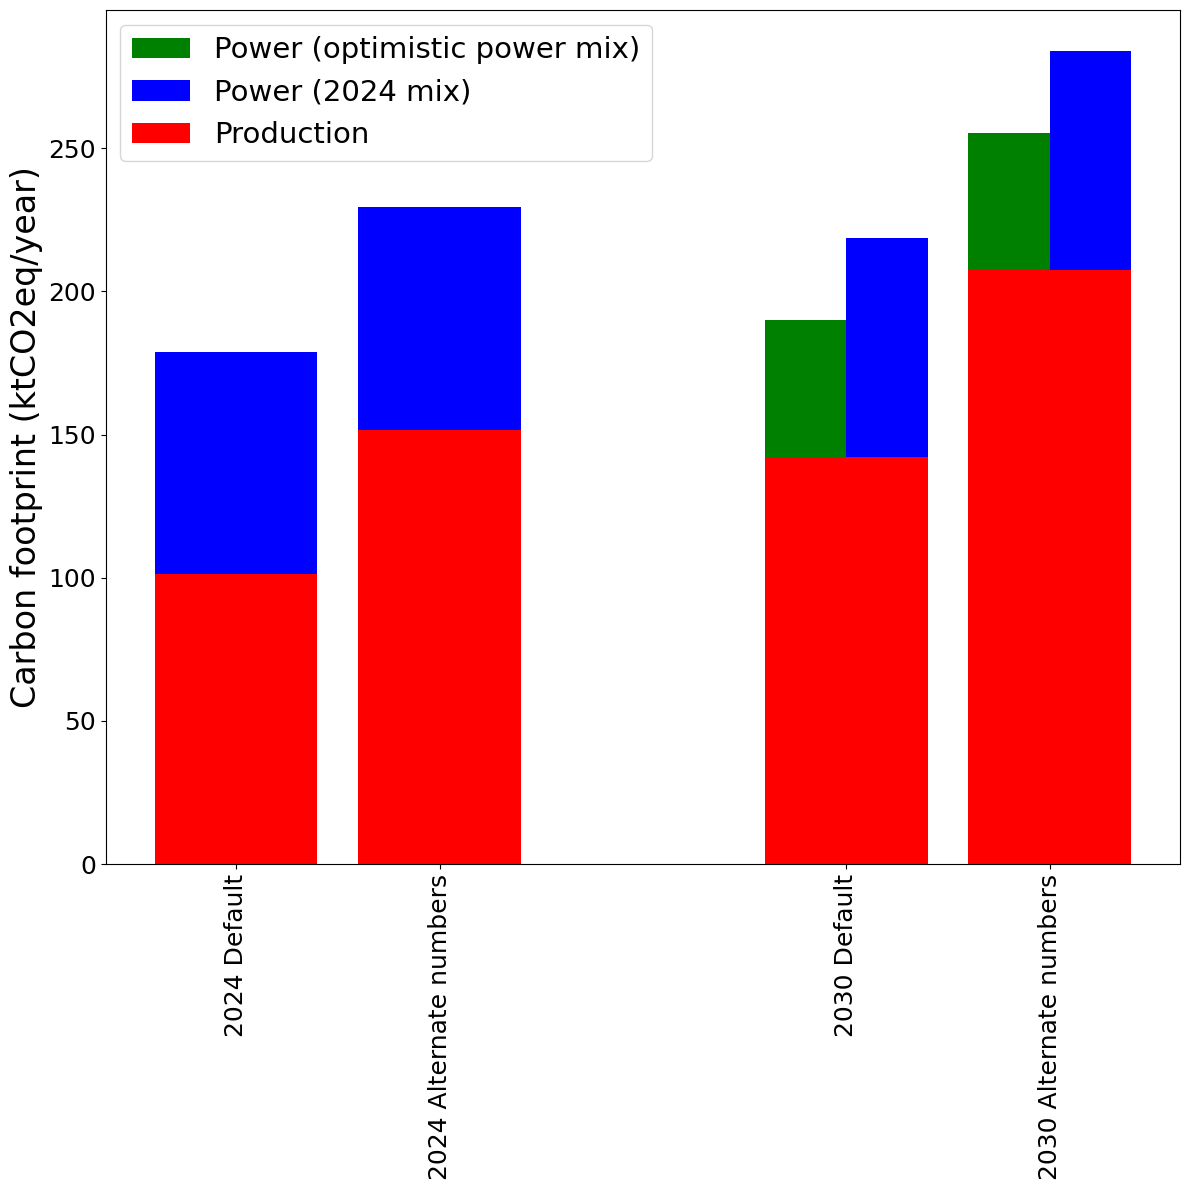

In [27]:
# Carbon footprint, taken from mael madon master thesis
# using utamo lifetimes
AU_HEPTABAND_CC_OTHER = AU_HEPTABAND_CC # keep the same
AU_RU_3500_CC_OTHER = (299 + 446) / 5
RU_CC_OTHER = 446 / 7
BU_CC_OTHER = 299 / 7

print(AU_RU_3500_CC_OTHER, RU_CC_OTHER, BU_CC_OTHER)
print(AU_RU_3500_CC, RU_CC, BU_CC)  


def calculate_prod_carbon_cost_other(counts):
    return (
        counts[0] / BU_CC * BU_CC_OTHER * 10**3
        + counts[1] * AU_RU_3500_CC_OTHER
        + counts[2] * RU_CC_OTHER
        + counts[3] * AU_HEPTABAND_CC
        + mast_costs[-1] # TODO: fix
    ) / 10**3

prod_carbon_cost_2023_other = calculate_prod_carbon_cost_other(last_counts)
prod_carbon_cost_2023_test = calculate_prod_carbon_cost([BU_costs[-1] / 10**3, nr_3500_counts[-1], trx_counts[-1], ant_counts[-1]])
test_counts = [BU_costs[-1] / 10**3, nr_3500_counts[-1], trx_counts[-1], ant_counts[-1]]
print(test_counts[0] * 10 ** 3, BU_costs[-1])
print(test_counts[1] * AU_RU_3500_CC, AAU_costs[-1])
print(test_counts[2] * RU_CC, RU_costs[-1])
print(test_counts[3] * AU_HEPTABAND_CC, AU_costs[-1])
print(mast_costs[-1])
print(prod_carbon_cost_2023, prod_carbon_cost_2023_test)
prod_carbon_cost_2030_base_other = calculate_prod_carbon_cost_other(interpolated_counts_2030)

plt.bar([3], [(prod_carbon_cost_2030_base + opt_carbon_costs[0]) / 10**3], color="g", label="Power (optimistic power mix)")
plt.bar([3 + 0.2], [(prod_carbon_cost_2030_base + pess_carbon_costs[0]) / 10**3], color="b", label="Power (2024 mix)", width=0.4)
plt.bar([3], [prod_carbon_cost_2030_base / 10**3], color="r", label="Production")

plt.bar([4], [(prod_carbon_cost_2030_base_other + opt_carbon_costs[0]) / 10**3], color="g")
plt.bar([4 + 0.2], [(prod_carbon_cost_2030_base_other + pess_carbon_costs[0]) / 10**3], color="b", width=0.4)
plt.bar([4], [prod_carbon_cost_2030_base_other / 10**3], color="r")

plt.bar([0], (prod_carbon_cost_2023 + pw_carbon_cost_2023) / 10**3, color="b")
plt.bar([0], prod_carbon_cost_2023 / 10**3, color="r")    
plt.bar([1], (prod_carbon_cost_2023_other + pw_carbon_cost_2023) / 10**3, color="b")    
plt.bar([1], prod_carbon_cost_2023_other / 10**3, color="r")    

plt.ylabel("Carbon footprint (ktCO2eq/year)", fontsize=24)
plt.xticks([i for i in range(5)], ["2024 Default", "2024 Alternate numbers", "", "2030 Default", "2030 Alternate numbers"], rotation=90)
plt.legend(fontsize=21)
plt.xticks([0, 1, 3, 4], fontsize=18)
plt.yticks(fontsize=18)
# font size of exponent
# plt.tick_params(axis='y', labelsize=18)
plt.tight_layout()
plt.savefig("./Graphs/Prod_carbon_cost_sensitivity_analysis.pdf")
plt.show()


0.00013403406813207105 0.00022366665504012972


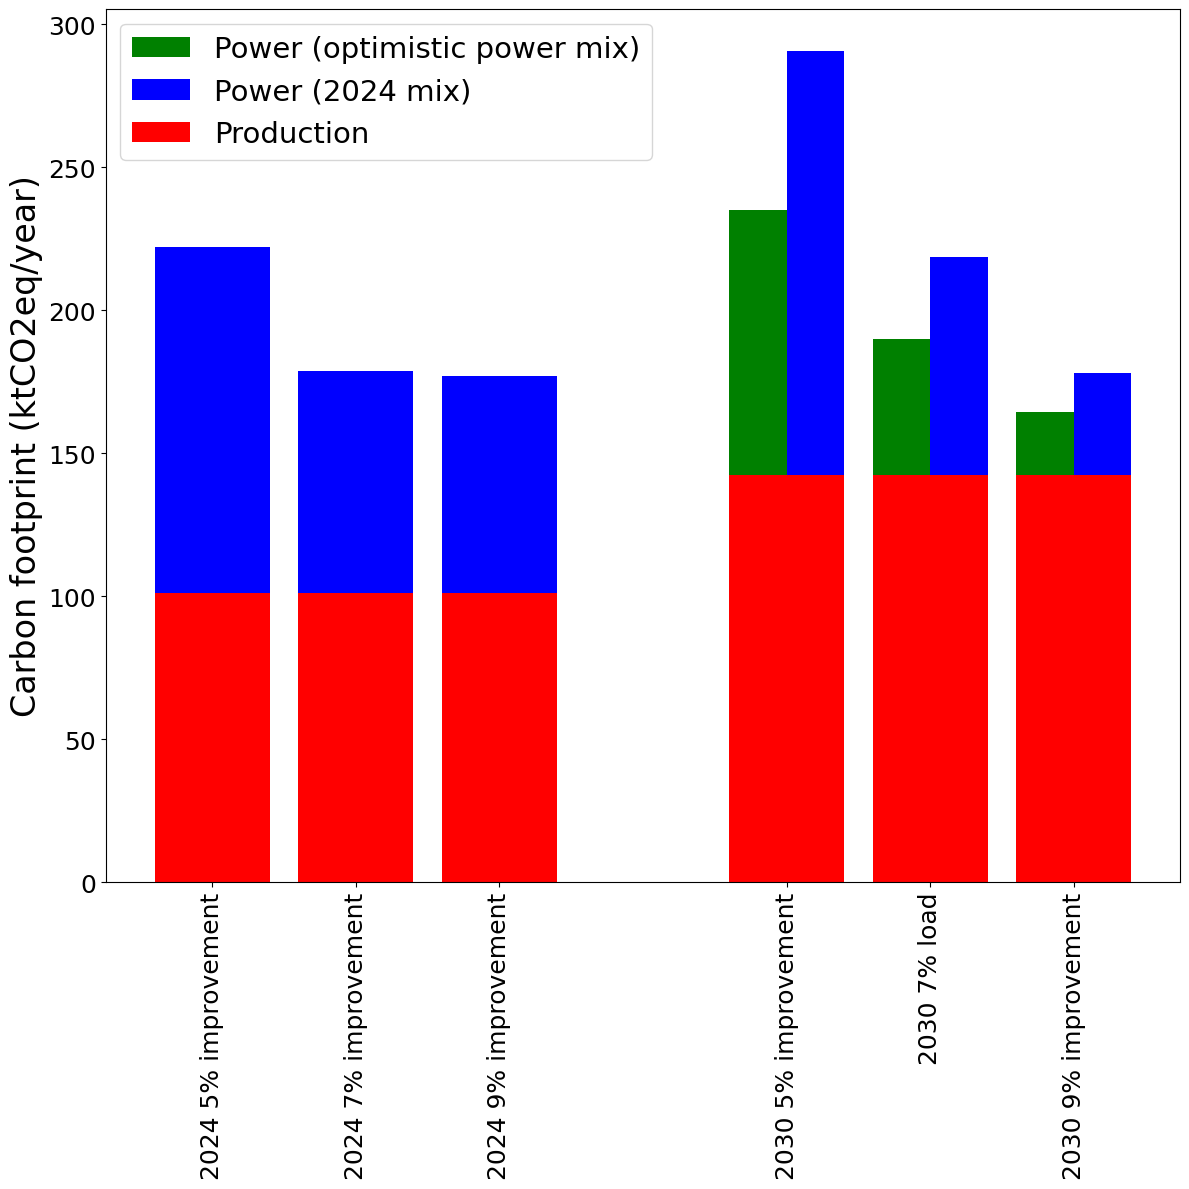

In [28]:
# Energy efficiency

opt_pw_carbon_cost_2030_high = (
    (
        convert_MW_to_kwh(AVG_PW_LTE_2030_HIGH) * interpolated_counts_2030[2]
        + convert_MW_to_kwh(AVG_PW_NR_2030_HIGH) * interpolated_counts_2030[1]
    )
    / 10**3
    * OPT_CARBON_INTENSITIES[-1]
) / 10**3

opt_pw_carbon_cost_2030_low = (
    (
        convert_MW_to_kwh(AVG_PW_LTE_2030_LOW) * interpolated_counts_2030[2]
        + convert_MW_to_kwh(AVG_PW_NR_2030_LOW) * interpolated_counts_2030[1]
    )
    / 10**3
    * OPT_CARBON_INTENSITIES[-1]
) / 10**3

pess_pw_carbon_cost_2030_high = (
    (
        convert_MW_to_kwh(AVG_PW_LTE_2030_HIGH) * interpolated_counts_2030[2]
        + convert_MW_to_kwh(AVG_PW_NR_2030_HIGH) * interpolated_counts_2030[1]
    )
    / 10**3
    * CARBON_INTENSITIES[-1]
) / 10**3

pess_pw_carbon_cost_2030_low = (
    (
        convert_MW_to_kwh(AVG_PW_LTE_2030_LOW) * interpolated_counts_2030[2]
        + convert_MW_to_kwh(AVG_PW_NR_2030_LOW) * interpolated_counts_2030[1]
    )
    / 10**3
    * CARBON_INTENSITIES[-1]
) / 10**3

pw_carbon_cost_2023_high = (
    (
        convert_MW_to_kwh(AVG_PW_LTE_HIGH) * last_counts[2]
        + convert_MW_to_kwh(AVG_PW_NR_HIGH) * last_counts[1]
    )
    / 10**3
    * CARBON_INTENSITIES[-1]
) / 10**3

pw_carbon_cost_2023_low = (
    (
        convert_MW_to_kwh(AVG_PW_LTE_LOW) * last_counts[2]
        + convert_MW_to_kwh(AVG_PW_NR_LOW) * last_counts[1]
    )
    / 10**3
    * CARBON_INTENSITIES[-1]
) / 10**3

print(AVG_PW_LTE_HIGH, AVG_PW_LTE_LOW)

plt.bar([4], [(opt_pw_carbon_cost_2030_low + prod_carbon_cost_2030_base) / 10**3], color="g", label="Power (optimistic power mix)")
plt.bar([4 + 0.2], [(pess_pw_carbon_cost_2030_low + prod_carbon_cost_2030_base) / 10**3], color="b", label="Power (2024 mix)", width=0.4)
plt.bar([4], [prod_carbon_cost_2030_base / 10**3], color="r", label="Production")
plt.bar([5], [opt_total_carbon_costs[0]], color="g")
plt.bar([5 + 0.2], [pess_total_carbon_costs[0]], color="b", width=0.4)
plt.bar([5], [prod_carbon_cost_2030_base / 10**3], color="r")
plt.bar([6], [(opt_pw_carbon_cost_2030_high  + prod_carbon_cost_2030_base) / 10**3], color="g")
plt.bar([6 + 0.2], [(pess_pw_carbon_cost_2030_high + prod_carbon_cost_2030_base) / 10**3], color="b", width=0.4)
plt.bar([6], [prod_carbon_cost_2030_base / 10**3], color="r")

plt.bar([0], (prod_carbon_cost_2023 + pw_carbon_cost_2023_low) / 10**3, color="b")    
plt.bar([0], prod_carbon_cost_2023 / 10**3, color="r")    
plt.bar([1], (prod_carbon_cost_2023 + pw_carbon_cost_2023) / 10**3, color="b")
plt.bar([1], prod_carbon_cost_2023 / 10**3, color="r")    
plt.bar([2], (prod_carbon_cost_2023 + pw_carbon_cost_2023_high) / 10**3, color="b")
plt.bar([2], prod_carbon_cost_2023 / 10**3, color="r")

plt.ylabel("Carbon footprint (ktCO2eq/year)", fontsize=24)
plt.xticks([i for i in range(7)], ["2024 5% improvement", "2024 7% improvement", "2024 9% improvement", "", "2030 5% improvement", "2030 7% load", "2030 9% improvement"], rotation=90)
plt.legend(fontsize=21)
plt.xticks([0, 1, 2, 4, 5, 6], fontsize=18)
plt.yticks(fontsize=18)
# font size of exponent
# plt.tick_params(axis='y', labelsize=18)
plt.tight_layout()
plt.savefig("./Graphs/Efficiency_sensitivity_analysis.pdf")
plt.show()


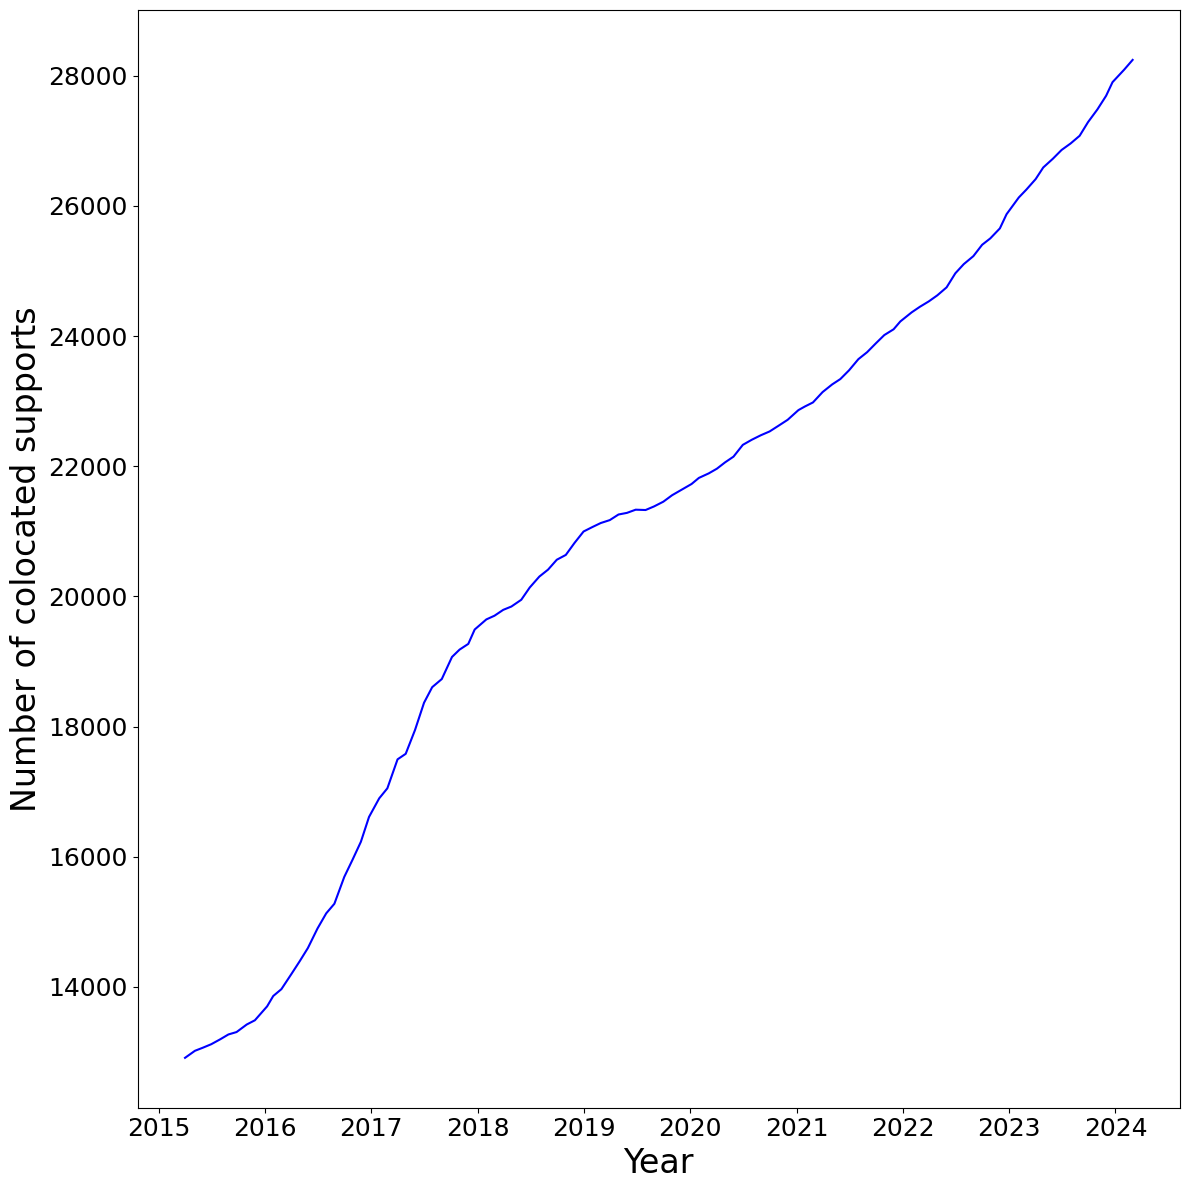

In [31]:
# graph colocated support

plt.plot(dates, colocated_supports, color='blue')
plt.xlabel('Year', fontsize=24)
plt.ylabel('Number of colocated supports', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# font size of exponent
# plt.tick_params(axis='y', labelsize=18)
plt.tight_layout()
plt.savefig('./Graphs/Colocated_support.pdf')
plt.show()